<a href="https://colab.research.google.com/github/sidhu2690/Heavy_rainfall_prediction/blob/main/best_model_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###### Data set can be found here(1991-2013) https://www.kaggle.com/datasets/sidhuser/era-5-1997-2013-semban

In [ ]:
!ls '/kaggle/input/era-5-1997-2013-semban'

1997_01.nc  2000_01.nc	2003_01.nc  2006_01.nc	2009_01.nc  2012_01.nc
1997_02.nc  2000_02.nc	2003_02.nc  2006_02.nc	2009_02.nc  2012_02.nc
1998_01.nc  2001_01.nc	2004-02.nc  2007_01.nc	2010_01.nc  2013_01.nc
1998_02.nc  2001_02.nc	2004_01.nc  2007_02.nc	2010_02.nc  2013_02.nc
1999_01.nc  2002_01.nc	2005_01.nc  2008_01.nc	2011_01.nc  2014_01.nc
1999_02.nc  2002_02.nc	2005_02.nc  2008_02.nc	2011_02.nc  2014_02.nc


In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

file_name = "2008_01.nc"

dataset = xr.open_dataset(f"/kaggle/input/era-5-1997-2013-semban/{file_name}")

target_var_name = 'tp'

data = dataset[target_var_name]

time_index = 2000

data_at_time = data.isel(time=time_index)

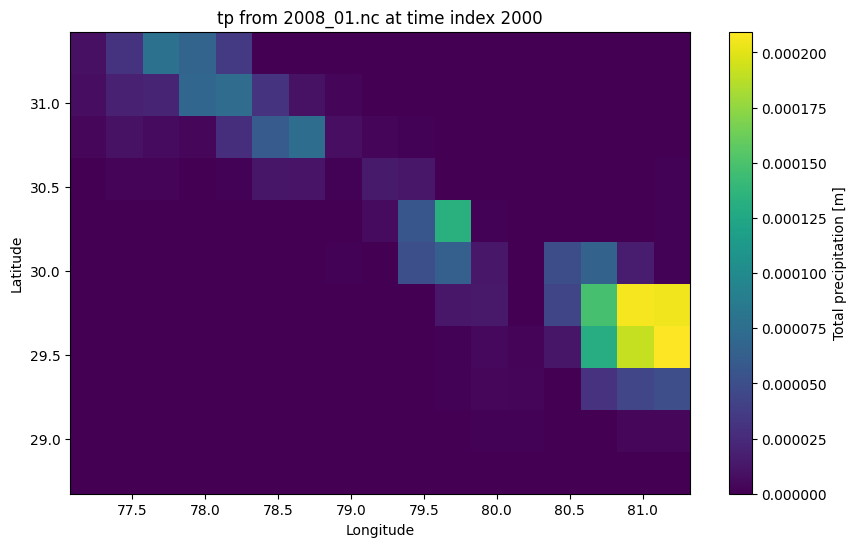

In [ ]:
plt.figure(figsize=(10, 6))
data_at_time.plot(x='longitude', y='latitude', cmap='viridis')
plt.title(f'{target_var_name} from {file_name} at time index {time_index}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [ ]:
time_coord = dataset['time']
num_time_steps = len(time_coord)
print(f"Number of time steps: {num_time_steps}")
variables = list(dataset.data_vars)
variables

Number of time steps: 4296


['t2m',
 'cbh',
 'hcc',
 'lcc',
 'msl',
 'mcc',
 'slhf',
 'sp',
 'sshf',
 'tcc',
 'tciw',
 'tclw',
 'tp']

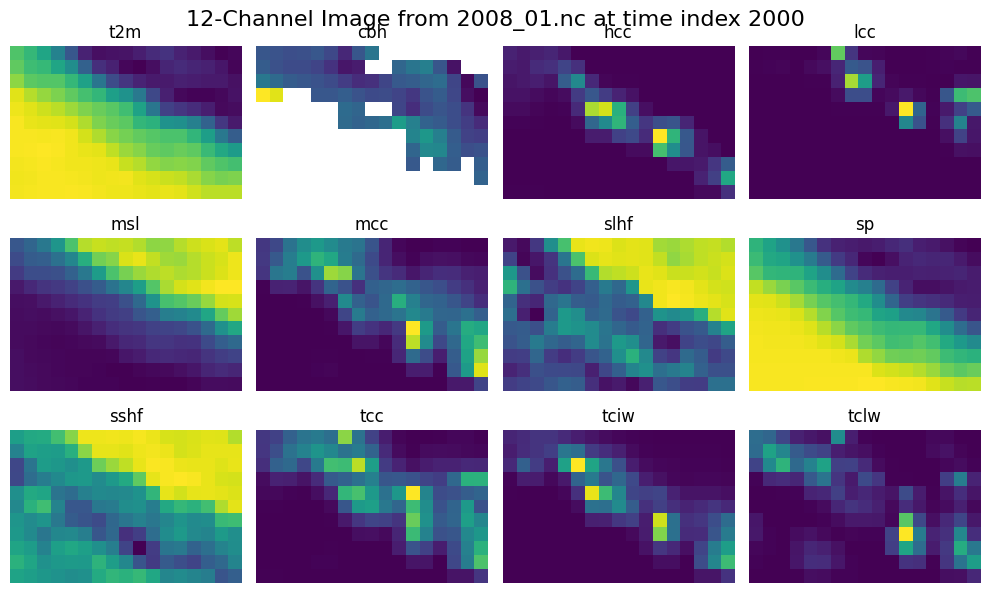

In [ ]:
target_var_name = 'tp'

feature_vars = [var for var in dataset.data_vars if var != target_var_name]

feature_images = []

for var in feature_vars:
    data_at_time = dataset[var].isel(time=time_index)
    feature_images.append(data_at_time)

feature_images_np = np.stack([data.values for data in feature_images], axis=-1)

fig, axes = plt.subplots(3, 4, figsize=(10,6))
fig.suptitle(f'12-Channel Image from {file_name} at time index {time_index}', fontsize=16)

axes = axes.flatten()

for i in range(12):
    ax = axes[i]
    ax.imshow(feature_images_np[:, :, i], cmap='viridis', aspect='auto')
    ax.set_title(feature_vars[i])
    ax.axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

In [ ]:
import xarray as xr
import numpy as np

file_names = [
    "1997_01.nc", "1997_02.nc", "1998_01.nc", "1998_02.nc", "1999_01.nc", "1999_02.nc",
    "2000_01.nc", "2000_02.nc", "2001_01.nc", "2001_02.nc", "2002_01.nc", "2002_02.nc",
    "2003_01.nc", "2003_02.nc", "2004_01.nc", "2004-02.nc", "2005_01.nc", "2005_02.nc",
    "2006_01.nc", "2006_02.nc", "2007_01.nc", "2007_02.nc", "2008_01.nc", "2008_02.nc",
    "2009_01.nc", "2009_02.nc", "2010_01.nc", "2010_02.nc", "2011_01.nc", "2011_02.nc",
    "2012_01.nc", "2012_02.nc", "2013_01.nc", "2013_02.nc", "2014_01.nc", "2014_02.nc"
]

features_list = []
target_list = []

variables_to_keep = ['t2m', 'lcc', 'mcc', 'slhf', 'sp', 'tcc', 'tciw', 'tclw']

for file_name in file_names:
    dataset = xr.open_dataset(f"/kaggle/input/era-5-1997-2013-semban/{file_name}")

    tp_data = dataset['tp'].mean(dim=('latitude', 'longitude')).values

    # Filter variables
    feature_vars = [var for var in dataset.data_vars if var in variables_to_keep]
    features_np = []

    for var in feature_vars:
        data = dataset[var].values
        nan_mask = np.isnan(data)
        data[nan_mask] = np.nanmean(data)
        features_np.append(data)

    features_np = np.stack(features_np, axis=-1)

    nan_mask_tp = np.isnan(tp_data)
    tp_data[nan_mask_tp] = np.nanmean(tp_data)

    features_list.append(features_np)
    target_list.append(tp_data)

features_np = np.concatenate(features_list, axis=0)
target_np = np.concatenate(target_list, axis=0)

num_time_steps = features_np.shape[0]

split_point = int(num_time_steps * 0.8)

X_train = features_np[:split_point]
y_train = target_np[:split_point]
X_test = features_np[split_point:]
y_test = target_np[split_point:]

X_train = X_train[:, np.newaxis, ...]
X_test = X_test[:, np.newaxis, ...]

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (125280, 1, 11, 17, 8)
y_train shape: (125280,)
X_test shape: (31320, 1, 11, 17, 8)
y_test shape: (31320,)


In [ ]:
from sklearn.preprocessing import MinMaxScaler

num_time_steps, time_steps, height, width, channels = X_train.shape
features_reshaped = X_train.reshape((num_time_steps, height * width * channels))

scaler = MinMaxScaler()
scaler.fit(features_reshaped)

X_train_standardized = scaler.transform(features_reshaped).reshape(X_train.shape)
X_test_standardized = scaler.transform(X_test.reshape((X_test.shape[0], height * width * channels))).reshape(X_test.shape)

target_scaler = MinMaxScaler()
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
target_scaler.fit(y_train)
y_train_standardized = target_scaler.transform(y_train).reshape(-1)
y_test_standardized = target_scaler.transform(y_test).reshape(-1)


Trial 10 Complete [00h 17m 05s]
val_loss: 0.00042494264198467135

Best val_loss So Far: 0.0003906882193405181
Total elapsed time: 02h 32m 42s


/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 48 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Best Learning Rate: 0.00010234591515410909
979/979 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step


W0000 00:00:1723125072.081862      78 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Root Mean Squared Error (RMSE): 0.0001
R-squared: 0.8900


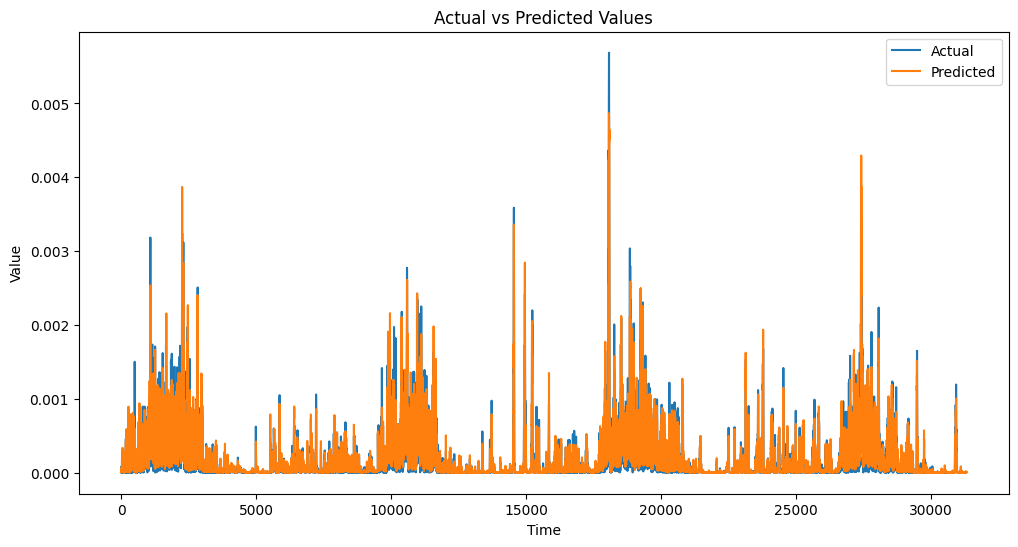

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
from kerastuner import HyperModel, RandomSearch

class TimeSeriesHyperModel(HyperModel):
    def build(self, hp):
        model = Sequential()
        model.add(TimeDistributed(Conv2D(64, (4, 4), activation='relu', padding='same'),
                                  input_shape=(None, 11, 17, 8)))
        model.add(TimeDistributed(MaxPooling2D((2, 2), padding='same')))
        model.add(TimeDistributed(Conv2D(64, (4, 4), activation='relu', padding='same')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2), padding='same')))
        model.add(TimeDistributed(Dropout(0.2)))
        model.add(TimeDistributed(Conv2D(128, (4, 4), activation='relu', padding='same')))
        model.add(TimeDistributed(MaxPooling2D((2, 2), padding='same')))
        model.add(TimeDistributed(Dropout(0.1)))
        model.add(TimeDistributed(Flatten()))
        model.add(LSTM(64, return_sequences=True, activation='relu', dropout=0.1))
        model.add(LSTM(64, return_sequences=True, activation='relu', dropout=0.1))
        model.add(LSTM(32, return_sequences=False, activation='relu', dropout=0.1))
        model.add(Dense(128, activation='relu'))
        model.add(Dense(256, activation='relu'))
        model.add(Dropout(0.3))
        model.add(Dense(1))

        # Tune learning rate
        learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
        model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')

        return model

# Set up the hyperparameter search for learning rate
hypermodel = TimeSeriesHyperModel()

tuner = RandomSearch(
    hypermodel,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='my_dir',
    project_name='learning_rate_search'
)

# Search for the best learning rate
tuner.search(X_train_standardized, y_train_standardized,
             epochs=30,
             batch_size=16,
             validation_data=(X_test_standardized, y_test_standardized),
             verbose=1)

# Get the best model and its parameters
best_model = tuner.get_best_models(num_models=1)[0]
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best Learning Rate:", best_hp.get('learning_rate'))

# Evaluate the best model
y_pred_standardized = best_model.predict(X_test_standardized)
y_pred = target_scaler.inverse_transform(y_pred_standardized)
y_test = target_scaler.inverse_transform(y_test_standardized.reshape(-1, 1)).flatten()

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared: {r2:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()
